# Million Song Dataset CRNN Classification

***
Music Genre classification


last.fm dataset citation, as required in the terms of usage at
http://millionsongdataset.com/

```
@INPROCEEDINGS{Bertin-Mahieux2011,
  author = {Thierry Bertin-Mahieux and Daniel P.W. Ellis and Brian Whitman and Paul Lamere},
  title = {The Million Song Dataset},
  booktitle = {{Proceedings of the 12th International Conference on Music Information
	Retrieval ({ISMIR} 2011)}},
  year = {2011},
  owner = {thierry},
  timestamp = {2010.03.07}
}
```
This notebook is heavily adapted from Timothy Mason's implementation of Choi et. al's "CONVOLUTIONAL RECURRENT NEURAL NETWORKS FOR MUSIC CLASSIFICATION"

Sources:

Mason's Implementation: https://github.com/tima0476/final_timothy_mason_csci5922_s20

Convolutional Recurrent Neural Network: 
K. Choi, G. Fazekas, M. Sandler and K. Cho, "Convolutional recurrent neural networks for music classification," 2017 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), 2017, pp. 2392-2396, doi: 10.1109/ICASSP.2017.7952585.

## Import of libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import os
from pathlib import Path
import json
from tqdm import tqdm      # for easy and attractive progress bars
import matplotlib.pyplot as plt

import hdf5_getters        # https://github.com/tbertinmahieux/MSongsDB/tree/master/PythonSrc
# hdf5_getters.py is Copyright 2010, Thierry Bertin-Mahieux
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

In [2]:
np.version.version

'1.19.4'

## Hyperparameters

In [3]:
segments = 252    # Minimum usable segment count
pickle_fn = f'./msd_subset_top50_{segments}.pickle'

input_shape = (segments, 12, 1)
channel_axis = 3
freq_axis = 2
time_axis = 1

# Hyperparms adapted from Choi, et. al for their 3,000,000 parameter size CRNN model
CNN_dropout = 0.1
# CNN1_N = 169
# CNN1_kernel = (3,3)
# CNN1_pool = (2,2)

CNN2_N = 339
CNN2_kernel = (3,3)
CNN2_pool = (2,2)

CNN3_N = 339
CNN3_kernel = (3,3)
CNN3_pool = (2,2)

CNN4_N = 339
CNN4_kernel = (3,3)
CNN4_pool = (3,3)

RNN_dropout = 0.3
RNN1_N = 169
RNN2_N = 169

training_batch_size=10
training_epochs=100

# # Hyperparms adapted from Choi, et. al for their 100,000 parameter size CRNN model
# CNN_dropout = 0.1
# # CNN1_N = 30
# # CNN1_kernel = (3,3)
# # CNN1_pool = (2,2)

# CNN2_N = 60
# CNN2_kernel = (3,3)
# CNN2_pool = (2,2)

# CNN3_N = 60
# CNN3_kernel = (3,3)
# CNN3_pool = (2,2)

# CNN4_N = 60
# CNN4_kernel = (3,3)
# CNN4_pool = (3,3)

# RNN_dropout = 0.3
# RNN1_N = 30
# RNN2_N = 30

# training_batch_size=10
# training_epochs=50

## Import data functions

In [4]:
# see http://docs.echonest.com.s3-website-us-east-1.amazonaws.com/_static/AnalyzeDocumentation.pdf for
# detailed discussion of the category data items
def hdf_tree_to_dataframe(msd_path='./MillionSongSubset/data',
                          categories=("track_id",
                                      "artist_name",          # Name of the artist
                                      "release",              # Album name
                                      "title",                # Title of the piece
                                      "year",                 # year released (unreliable - often 0)
                                      "segments_pitches",     # list of 12-ary vectors, each contains relative
                                                              # strength of the notes (pitches) contained in 
                                                              # a segment.  0 = strength(0..1) of the C note, 
                                                              # 1 = strength of C-sharp, 
                                                              # ... 
                                                              # 11 = B
                                      "segments_timbre",      # list of 12-ary vectors, "timbre is the quality
                                                              # of a musical note or sound that distinguishes 
                                                              # different types of musical instruments, or 
                                                              # voices. It is a complex notion also referred 
                                                              # to as sound color, texture, or tone quality, 
                                                              # and is derived from the shape of a segment’s 
                                                              # spectro-temporal surface, independently of 
                                                              # pitch and loudness. "
                                     ), 
                          first = 0, last = None):
    """
    Walk the directory structure of the provided path, and read data from the
    *.h5 files in all subdirectories.

    Parameters
    ----------
    categories: set of keyword strings.  Note:  'track_id' is the index field, so it will always read
        that category, whether it is specified or not.
    msd_path: The path to the root directory of the MSD dataset
    first: Index of the first file to read
    last: Index of the last file to read.  If None, then read entire list of files

    Returns
    -------
    a Pandas dataframe object containing the specified categories of MSD data
    """

    file_list = [f for f in Path(msd_path).glob('**/*.h5')]

    if last == None:
        last = len(file_list)
    data = []

    for f in tqdm(file_list[first:last], desc=f"Loading subset of MSD"):
        h5file = hdf5_getters.open_h5_file_read(f)
        d = {}
        for c in categories:
            t = getattr(hdf5_getters, "get_"+c)(h5file)
            # Truncate segments to fixed size
            if c=='segments_pitches':
                d[c] = t[:segments]
            elif c=='segments_timbre':
                d[c] = t[:segments]
            else:
                d[c] = t
        h5file.close()
        
        # Only keep records with at least the minimum number of segments
        if len(d['segments_pitches']) >= segments:
            data.append(d)
            
    return pd.DataFrame(data)

def json_tree_to_dataframe( lfm_path='./lastfm_subset' ):
    """
    Load the tags from all JSON files at the specified directory and its' subdirectories
    into a Pandas DataFrame.  Index by track_id and also keep artist and title for more precise matching
    to the MSD.  Result is filtered to only return entries which have tags in the top-50.  Assumes that
    the list of last.fm top 50 tags is in the file top50_lastfm_tags.csv in the current working directory.
    
    Parameters
    ----------
    lfm_path: The path to the root directory of the last.fm dataset

    Returns
    -------
    a Pandas DataFrame object containing the entire dataset, filtered to only contain entries which
    have tags in the top 50 of last.fm tags.
    """
    
    # load the top 50 tags into a set because set intersection will be an elegant way to only keep those
    # tags which are in the top 50.
    top50 = set(pd.read_csv('top50_lastfm_tags.csv').Tag)
    
    # Appending one record at a time to a Pandas DataFrame is inefficient, so build a simple list
    # in memory, then create the Pandas DataFrame in one shot from that list
    data = []
    for file_path in tqdm([f for f in Path(lfm_path).glob('**/*.json')], desc="Loading last.fm tags"):
        with open(file_path) as json_data:     # with... syntax benefits from automatic file closing
            j = json.load(json_data)
            
            # change the key for the name of the artist to have consistent naming with the MSD
            j['artist_name'] = j.pop('artist') 
            
            if j['tags']:      # skip tag-less entries
                # Only keep the tags, and only if they are in the top50 set.  Do the list filtering by
                # using set intersection of the top50 set and use column slice feature of a numpy array to
                # extract just the tag names.  (The JSON file has both the tag name and an integer number
                # for each tag - I don't need that integer number)
                t = list(top50.intersection(np.array(j['tags'])[:,0]))
                if t:
                    j['top50_tags'] = t
                    data.append(j)
    
    return pd.DataFrame(data)[['track_id','artist_name','title','top50_tags']] # only keep the useful bits


## Load and merge the datasets

In [5]:
import os.path

if os.path.isfile(pickle_fn):
    # This dataset has already been generated.  Load the snapshot
    df = pd.read_pickle(pickle_fn)
else:
    # A snapshot is not available for this dataset.  Load it then save the snapshot
    lfm_df = json_tree_to_dataframe()
    msd_df = hdf_tree_to_dataframe()
    df = msd_df.merge( right=lfm_df, on=('track_id','title','artist_name') )

    # Allow the interim dataframes to be garbage collected
    msd_df = lfm_df = None

    df.to_pickle(pickle_fn)
    print(f"Created snapshot file {pickle_fn}")


### Inspect the final dataset

In [6]:
allTags = set()
for i in df["top50_tags"]:
    for tag in i:
        allTags.add(tag)
allTags

{'00s',
 '70s',
 '80s',
 '90s',
 'Awesome',
 'Favorite',
 'Favourites',
 'Hip-Hop',
 'Love',
 'Mellow',
 'acoustic',
 'alternative',
 'alternative rock',
 'ambient',
 'american',
 'beautiful',
 'blues',
 'british',
 'catchy',
 'chill',
 'chillout',
 'classic rock',
 'cool',
 'country',
 'dance',
 'easy listening',
 'electronic',
 'electronica',
 'experimental',
 'favorites',
 'female vocalist',
 'female vocalists',
 'folk',
 'guitar',
 'hard rock',
 'indie',
 'indie rock',
 'instrumental',
 'jazz',
 'male vocalists',
 'metal',
 'oldies',
 'party',
 'pop',
 'punk',
 'rock',
 'seen live',
 'sexy',
 'singer-songwriter',
 'soul'}

In [7]:
filtLst = ["a", "b", "c"]
allLst = filtLst + ["d", "e", "f"]
finalLst = [i for i in allLst if i in filtLst]
finalLst

['a', 'b', 'c']

In [8]:
for i in range(10, -1, -1):
    print(i)

10
9
8
7
6
5
4
3
2
1
0


In [9]:
moodTags = ["oldies", "ambient", "chillout", "Mellow", "party", "beautiful", "easy listening", "chill", "sad", "sexy", "catchy", "happy"]
backupDf = df.copy()
moodDf = df.copy()

found = False
for i in range(len(moodDf)-1, -1, -1): #for each entry in df
    for mood in moodTags: 
        if mood in moodDf["top50_tags"][i]:
            found = True
    if found:
        found = False
        continue
    else:
        moodDf = moodDf.drop(i)

df = moodDf
df

,track_id,artist_name,release,title,year,segments_pitches,segments_timbre,top50_tags
1,TRAAABD128F429CF47,The Box Tops,Dimensions,Soul Deep,1969,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[pop, beautiful, rock, Love, oldies, soul, cla..."
6,TRAABVM128F92CA9DC,Tesla,Gold,Caught In A Dream,2004,"[[1.0, 0.961, 0.459, 0.496, 0.532, 0.54, 0.546...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[Awesome, metal, 00s, rock, Favorite, Love, ha..."
7,TRAACER128F4290F96,The Dillinger Escape Plan,Miss Machine,Setting Fire to Sleeping Giants,2004,"[[0.946, 1.0, 0.75, 0.737, 0.749, 0.739, 0.738...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[metal, jazz, experimental, pop, beautiful, ro..."
9,TRAACNS128F14A2DF5,Willie Bobo,Willie Bobo's Finest Hour,Spanish Grease,1997,"[[0.995, 1.0, 0.43, 0.399, 0.3, 0.347, 0.411, ...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[jazz, Favourites, american, beautiful, Favori..."
12,TRAADEV128F9348C0A,Javier Navarrete,Cracks,Midnight Swim,0,"[[0.021, 0.012, 0.012, 0.011, 0.024, 0.062, 0....","[[13.963, -75.409, -66.367, -164.069, 47.249, ...",[beautiful]
...,...,...,...,...,...,...,...,...
2351,TRBIGRY128F42597B3,Sade,Lovers Rock,All About Our Love,2000,"[[0.281, 0.459, 1.0, 0.805, 0.351, 0.281, 0.2,...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[80s, sexy, female vocalist, blues, jazz, ambi..."
2356,TRBIJES12903CF5B12,Mouth Of The Architect,111,Harboring An Apparition,2006,"[[0.137, 0.04, 0.078, 0.334, 0.071, 0.033, 0.0...","[[11.958, 68.461, -30.368, -69.307, 14.95, 9.9...","[metal, beautiful, 00s, experimental]"
2357,TRBIJIA128F425F57D,David Arkenstone,Return Of The Guardians,The Forgotten Lands,1996,"[[0.478, 0.39, 0.381, 0.429, 0.369, 0.516, 0.5...","[[1.124, 169.042, 43.48, -51.969, 45.984, -58....","[jazz, chillout, chill, instrumental]"
2359,TRBIJMU12903CF892B,Moonspell,Sin / Pecado,The Hanged Man,1998,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[metal, sexy, acoustic, seen live, beautiful]"


### Sample Data Visualization


    Song: Where You Belong
  Artist: The Summer Obsession
 Release: This Is Where You Belong
Released: 2006
    Tags: ['dance', 'punk', 'Mellow', 'pop', 'chill', 'Love', 'alternative', 'catchy', 'Awesome']


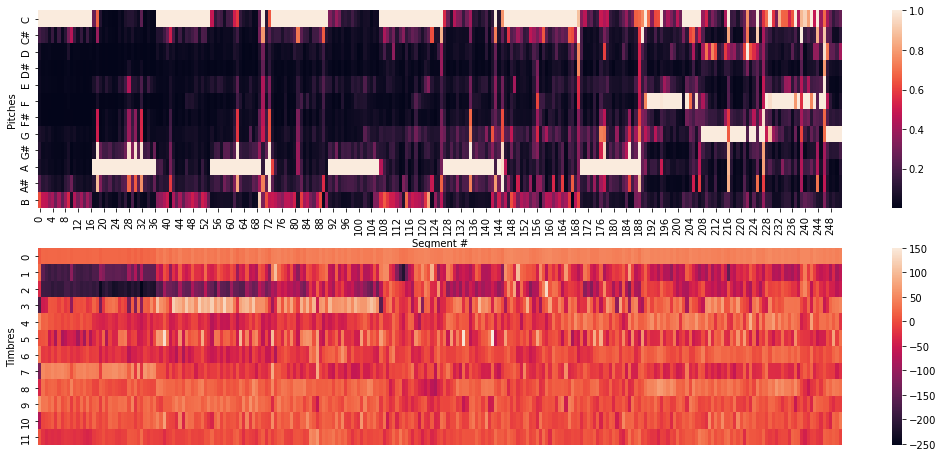

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline

x = random.randint(0,df.shape[0]-2)

for i in df.index[x:x+1]:
    name = f'    Song: {df.title[i]}\n  Artist: {df.artist_name[i]}\n Release: {df.release[i]}'
    if df.year[i] != 0:
        name += f'\nReleased: {df.year[i]}'
    name += '\n'
    name += f'    Tags: {df.top50_tags[i]}'
    print(name)
    
    # plot a scatterplot of the segment starts
    plt.figure(figsize=(18,8))

    # plot a heatmap of the pitch data
    plt.subplot(2,1,1)
    ax = sns.heatmap(df.segments_pitches[i].T, 
                     yticklabels=("C", "C#", "D", "D#", "E", "F", "F#", "G",
                                 "G#", "A", "A#", "B")
                    )
    ax.set(ylabel="Pitches")
    ax.set(xlabel="Segment #")

    # plot a heatmap of the timbre data
    plt.subplot(2,1,2)
    ax = sns.heatmap(df.segments_timbre[i].T, xticklabels=False)
    ax.set(ylabel="Timbres")
    plt.show()
    plt.close()
    

## Build The CRNN

In [11]:
#
# model adapted from music_tagger_crnn.py at https://github.com/keunwoochoi/music-auto_tagging-keras
#

model = tf.keras.Sequential()

# Input block
model.add(layers.Input(shape=input_shape))
# model.add(layers.ZeroPadding2D(padding=(0, 37)))
model.add(layers.BatchNormalization(axis=freq_axis, name='bn_0_freq'))

# First Convolutional Block
#   Choi et. al, used 4 CNN blocks, but the data set I'm using is too narrow (12 as opposed to 96) to 
#   support 4 blocks, so I'm omitting the first block.
# model.add(layers.Conv2D(filters=CNN1_N, kernel_size=CNN1_kernel, padding='same', name='conv1'))
# model.add(layers.BatchNormalization(axis=channel_axis, name='bn1'))
# model.add(layers.ELU())
# model.add(layers.MaxPool2D(pool_size=CNN1_pool, strides=CNN1_pool, name='pool1'))
# model.add(layers.Dropout(rate=CNN_dropout, name='dropout1'))

# Second Convolutional Block
model.add(layers.Conv2D(filters=CNN2_N, kernel_size=CNN2_kernel, padding='same', name='conv2'))
model.add(layers.BatchNormalization(axis=channel_axis, name='bn2'))
model.add(layers.ELU())
model.add(layers.MaxPool2D(pool_size=CNN2_pool, strides=CNN2_pool, name='pool2'))
model.add(layers.Dropout(rate=CNN_dropout, name='dropout2'))

# Third Convolutional Block
model.add(layers.Conv2D(filters=CNN3_N, kernel_size=CNN3_kernel, padding='same', name='conv3'))
model.add(layers.BatchNormalization(axis=channel_axis, name='bn3'))
model.add(layers.ELU())
model.add(layers.MaxPool2D(pool_size=CNN3_pool, strides=CNN3_pool, name='pool3'))
model.add(layers.Dropout(rate=CNN_dropout, name='dropout3'))

# Fourth convolutional Block
model.add(layers.Conv2D(filters=CNN4_N, kernel_size=CNN4_kernel, padding='same', name='conv4'))
model.add(layers.BatchNormalization(axis=channel_axis, name='bn4'))
model.add(layers.ELU())
model.add(layers.MaxPool2D(pool_size=CNN4_pool, strides=CNN4_pool, name='pool4'))
dropout4 = layers.Dropout(rate=CNN_dropout, name='dropout4') # save this layer for retrieving output shape
model.add(dropout4)

# reshaping
model.add(layers.Reshape(target_shape=(dropout4.output_shape[1], CNN4_N)))

# # RNN (GRU) blocks
# gru1 = layers.GRU(units=RNN1_N, return_sequences=True, name='gru1')
# gru2 = layers.GRU(units=RNN2_N, return_sequences=False, name='gru2')
# model.add(gru1)
# model.add(gru2)
model.add(layers.GRU(units=RNN1_N, return_sequences=True, name='gru1'))
model.add(layers.GRU(units=RNN2_N, return_sequences=False, name='gru2'))
# model.add(layers.Dropout(rate=RNN_dropout))

# Output
model.add(layers.Dense(units=50, activation='sigmoid', name='output'))


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn_0_freq (BatchNormalizatio (None, 252, 12, 1)        48        
_________________________________________________________________
conv2 (Conv2D)               (None, 252, 12, 339)      3390      
_________________________________________________________________
bn2 (BatchNormalization)     (None, 252, 12, 339)      1356      
_________________________________________________________________
elu (ELU)                    (None, 252, 12, 339)      0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 126, 6, 339)       0         
_________________________________________________________________
dropout2 (Dropout)           (None, 126, 6, 339)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 126, 6, 339)       1

### Compile The Model

In [13]:
#
# Compile the model
#
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.AUC()])



## Exploring the dataset

In [17]:
backupDf

,track_id,artist_name,release,title,year,segments_pitches,segments_timbre,top50_tags
0,TRAAAAW128F429D538,Casual,Fear Itself,I Didn't Mean To,0,"[[0.946, 0.684, 0.679, 0.941, 0.744, 0.633, 0....","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",[Hip-Hop]
1,TRAAABD128F429CF47,The Box Tops,Dimensions,Soul Deep,1969,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[pop, beautiful, rock, Love, oldies, soul, cla..."
2,TRAAAEF128F4273421,Adam Ant,Friend Or Foe,Something Girls,1982,"[[0.651, 0.592, 0.647, 0.494, 0.683, 0.919, 1....","[[24.937, 37.465, 177.22, -216.443, 56.3, 202....",[80s]
3,TRAAAFD128F92F423A,Gob,Muertos Vivos,Face the Ashes,2007,"[[1.0, 0.529, 0.407, 0.423, 0.524, 0.509, 0.65...","[[0.089, 169.621, 5.435, -30.061, 54.144, -50....",[punk]
4,TRAABLR128F423B7E3,Blue Rodeo,Outskirts,Floating,1987,"[[0.06, 0.073, 0.136, 0.034, 0.065, 0.073, 0.0...","[[33.542, -72.473, 64.169, -43.401, 27.579, 56...","[blues, classic rock, singer-songwriter, country]"
...,...,...,...,...,...,...,...,...
2357,TRBIJIA128F425F57D,David Arkenstone,Return Of The Guardians,The Forgotten Lands,1996,"[[0.478, 0.39, 0.381, 0.429, 0.369, 0.516, 0.5...","[[1.124, 169.042, 43.48, -51.969, 45.984, -58....","[jazz, chillout, chill, instrumental]"
2358,TRBIJLT12903CE7070,Blind Willie Johnson,Praise God I'm Satisfied,God Don't Never Change,1989,"[[0.899, 1.0, 0.854, 0.843, 0.569, 0.567, 0.18...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[singer-songwriter, blues]"
2359,TRBIJMU12903CF892B,Moonspell,Sin / Pecado,The Hanged Man,1998,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...","[metal, sexy, acoustic, seen live, beautiful]"
2360,TRBIJNF128F14815A7,Danny Williams,Collection,The Wonderful World Of The Young,1998,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 171.13, 9.469, -28.48, 57.491, -50.067,...",[oldies]


### Set up Training Data

In [37]:
from sklearn.preprocessing import MultiLabelBinarizer

# The pitch data is stored as a 1-dim ndarry of lists, but we need a 3D array.  Conversion is adapted from answer #9 at
# https://stackoverflow.com/questions/34156639/tensorflow-python-valueerror-setting-an-array-element-with-a-sequence-in-t/34157312
batch_xs = np.vstack([np.expand_dims(x, 0) for x in df.segments_pitches.values])

X = tf.expand_dims(tf.convert_to_tensor(value=batch_xs, dtype=tf.float32), 3) 

# Use an sklearn convenience utility to create a one-hot encoding of the truth values
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df.top50_tags)
encoded_classes = tuple(mlb.classes_)


### Fit the Model

In [38]:
print(f"Input data shape = {X.shape}")
history = model.fit(X, Y,
          batch_size=training_batch_size,
          epochs=training_epochs,
          verbose=1,
          use_multiprocessing=True,
          validation_split=0.05
         )
model.summary()

Input data shape = (860, 252, 12, 1)
Epoch 1/100
82/82 [==============================] - 16s 44ms/step - loss: 0.4673 - auc: 0.6417 - val_loss: 0.4946 - val_auc: 0.6094
Epoch 2/100
82/82 [==============================] - 2s 29ms/step - loss: 0.4506 - auc: 0.6752 - val_loss: 0.4967 - val_auc: 0.6128
Epoch 3/100
82/82 [==============================] - 3s 31ms/step - loss: 0.4444 - auc: 0.6927 - val_loss: 0.5106 - val_auc: 0.6034
Epoch 4/100
82/82 [==============================] - 3s 32ms/step - loss: 0.4400 - auc: 0.7032 - val_loss: 0.5157 - val_auc: 0.6033
Epoch 5/100
82/82 [==============================] - 3s 31ms/step - loss: 0.4326 - auc: 0.7193 - val_loss: 0.4954 - val_auc: 0.6309
Epoch 6/100
82/82 [==============================] - 3s 32ms/step - loss: 0.4323 - auc: 0.7202 - val_loss: 0.4741 - val_auc: 0.6485
Epoch 7/100
82/82 [==============================] - 3s 32ms/step - loss: 0.4241 - auc: 0.7370 - val_loss: 0.4799 - val_auc: 0.6460
Epoch 8/100
82/82 [===================

Epoch 62/100
82/82 [==============================] - 3s 32ms/step - loss: 0.0280 - auc: 0.9999 - val_loss: 1.0966 - val_auc: 0.5832
Epoch 63/100
82/82 [==============================] - 3s 32ms/step - loss: 0.0255 - auc: 1.0000 - val_loss: 1.1638 - val_auc: 0.5553s - loss: 0.0252 - au
Epoch 64/100
82/82 [==============================] - 3s 32ms/step - loss: 0.0246 - auc: 1.0000 - val_loss: 1.1167 - val_auc: 0.5638
Epoch 65/100
82/82 [==============================] - 3s 32ms/step - loss: 0.0235 - auc: 1.0000 - val_loss: 1.1567 - val_auc: 0.5751s - 
Epoch 66/100
82/82 [==============================] - 3s 32ms/step - loss: 0.0225 - auc: 1.0000 - val_loss: 1.1485 - val_auc: 0.5667 auc: 1.
Epoch 67/100
82/82 [==============================] - 3s 32ms/step - loss: 0.0210 - auc: 1.0000 - val_loss: 1.1732 - val_auc: 0.5730 - loss: 0.0196 - ETA: 0s - loss: 0.0210 - auc: 1.000 - ETA: 0s - loss: 0.0210 -
Epoch 68/100
82/82 [==============================] - 3s 32ms/step - loss: 0.0195 - auc: 

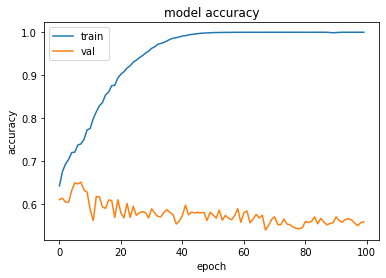

In [47]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

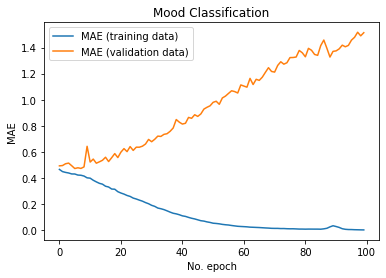

In [43]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('Mood Classification')
plt.ylabel('MAE')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [44]:
# Plot history: MSE
plt.plot(history.history['mean_squared_error'], label='MSE (training data)')
plt.plot(history.history['val_mean_squared_error'], label='MSE (validation data)')
plt.title('MSE for Chennai Reservoir Levels')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

KeyError: 'mean_squared_error'

In [ ]:
#todo list
#train two different models, one using all one using mood only
#Compare both using both
